In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Uninst

In [ ]:
!pip install scikit-learn matplotlib

In [ ]:
!pip install matplotlib


DBSCAN found 4 clusters (excluding outliers)
Cluster 0:
  min=(-6.550, -1.713, -0.797), max=(8.617, 1.237, 1.461)
  center=(1.033, -0.238, 0.332), size=(15.167, 2.950, 2.258)
Cluster 1:
  min=(10.372, 0.554, -0.886), max=(11.410, 1.101, 1.011)
  center=(10.891, 0.827, 0.063), size=(1.038, 0.547, 1.897)
Cluster 2:
  min=(5.836, 1.935, -0.009), max=(5.908, 2.214, 1.125)
  center=(5.872, 2.074, 0.558), size=(0.072, 0.279, 1.134)
Cluster 3:
  min=(22.380, -1.531, -1.016), max=(22.951, 0.819, 0.924)
  center=(22.665, -0.356, -0.046), size=(0.571, 2.350, 1.940)


<ipython-input-9-4aba209a59cd>:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


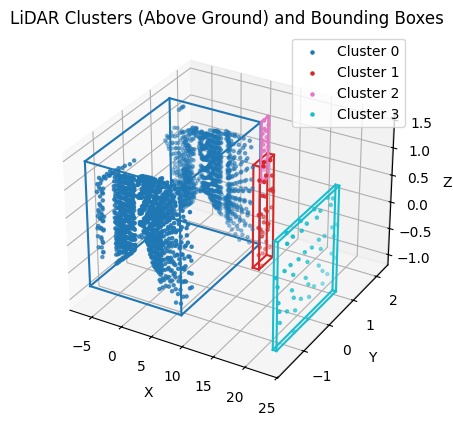

In [9]:
#!/usr/bin/env python3

import re
import numpy as np
import struct

import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

# ----------------------------------------------------------------------
# 1) Parse PointCloud2 text file (no ROS needed)
# ----------------------------------------------------------------------
def parse_pointcloud2_file(file_path):
    """
    Reads a text file containing sensor_msgs.msg.PointCloud2(...) with data=[...].
    Extracts each point (x, y, z, intensity, tag, line, timestamp).
    Returns np.ndarray shape (N,7).
    """
    with open(file_path, 'r') as f:
        text = f.read()

    match = re.search(r'data=\[([^\]]*)\]', text)
    if not match:
        raise ValueError("Could not find 'data=[...]' block in the file.")

    data_str = match.group(1)
    raw_values = [x.strip() for x in data_str.split(',') if x.strip()]
    byte_vals = np.array([int(v) for v in raw_values], dtype=np.uint8)

    # point_step=26 => fields: x,y,z,intensity (float32), tag,line (uint8), timestamp (float64)
    step = 26
    fmt = '<4f2Bd'  # 4 float32, 2 uint8, 1 float64 (little-endian)
    n_points = len(byte_vals) // step

    points = []
    offset = 0
    for _ in range(n_points):
        chunk = byte_vals[offset:offset+step]
        offset += step
        x, y, z, intensity, tag, line, timestamp = struct.unpack(fmt, chunk.tobytes())
        points.append([x, y, z, intensity, tag, line, timestamp])

    return np.array(points, dtype=np.float64)

# ----------------------------------------------------------------------
# 2) DBSCAN Clustering and Bounding Boxes
# ----------------------------------------------------------------------
def cluster_points_dbscan(xyz, eps=0.8, min_samples=20):
    """
    Clusters 3D points with DBSCAN and returns an array of labels.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(xyz)
    return db.labels_

def compute_bounding_boxes(xyz, labels):
    """
    For each cluster label (excluding -1), compute axis-aligned bounding box.
    Returns a list of dicts: {
        "cluster_id": cid,
        "min": (xmin,ymin,zmin),
        "max": (xmax,ymax,zmax)
    }
    """
    bboxes = []
    unique_labels = set(labels) - {-1}  # exclude outliers
    for cid in unique_labels:
        indices = np.where(labels == cid)[0]
        pts = xyz[indices]
        xyz_min = pts.min(axis=0)
        xyz_max = pts.max(axis=0)
        bboxes.append({
            "cluster_id": int(cid),
            "min": tuple(xyz_min),
            "max": tuple(xyz_max)
        })
    return bboxes

# ----------------------------------------------------------------------
# 3) Matplotlib 3D Plot
# ----------------------------------------------------------------------
def draw_aabb(ax, xyz_min, xyz_max, color='r'):
    (xmin, ymin, zmin) = xyz_min
    (xmax, ymax, zmax) = xyz_max

    # 8 corners
    corners = np.array([
        [xmin, ymin, zmin],
        [xmin, ymin, zmax],
        [xmin, ymax, zmin],
        [xmin, ymax, zmax],
        [xmax, ymin, zmin],
        [xmax, ymin, zmax],
        [xmax, ymax, zmin],
        [xmax, ymax, zmax]
    ])

    # 12 edges connecting corners
    edges = [
        (0,1), (0,2), (2,3), (1,3),
        (4,5), (4,6), (6,7), (5,7),
        (0,4), (1,5), (2,6), (3,7)
    ]
    for (start, end) in edges:
        ax.plot3D(
            [corners[start,0], corners[end,0]],
            [corners[start,1], corners[end,1]],
            [corners[start,2], corners[end,2]],
            color=color
        )

def plot_clusters_and_bboxes(xyz, labels, bboxes):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = set(labels) - {-1}
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    for cid in unique_labels:
        mask = (labels == cid)
        cluster_points = xyz[mask]
        color = colors(cid % 10)
        ax.scatter(
            cluster_points[:,0], cluster_points[:,1], cluster_points[:,2],
            s=5, c=[color], label=f"Cluster {cid}"
        )

    # Draw bounding boxes
    for box in bboxes:
        cid = box["cluster_id"]
        xyz_min = box["min"]
        xyz_max = box["max"]
        color = colors(cid % 10)
        draw_aabb(ax, xyz_min, xyz_max, color=color)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.title("LiDAR Clusters (Above Ground) and Bounding Boxes")
    plt.show()

# ----------------------------------------------------------------------
# 4) Main flow: parse -> remove ground -> cluster -> compute boxes -> print -> plot
# ----------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Parse raw file
    file_path = "/content/livox_data-2.txt"  # Replace with your real file path
    points = parse_pointcloud2_file(file_path)  # shape (N,7)
    xyz_full = points[:, :3]  # (N,3)

    # 2) Convert to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz_full)

    # (Optional) downsample to reduce noise
    pcd_down = pcd.voxel_down_sample(voxel_size=0.1)

    # 3) Remove ground plane using RANSAC
    distance_threshold = 0.2  # adjust this for your data
    plane_model, inliers = pcd_down.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=3,
        num_iterations=1000
    )
    # inliers = ground, invert=True => above ground
    pcd_obstacles = pcd_down.select_by_index(inliers, invert=True)

    # Convert back to NumPy
    xyz_obstacles = np.asarray(pcd_obstacles.points)

    # 4) Cluster the above-ground points
    eps = 0.8        # adjust DBSCAN neighborhood radius
    min_samples = 20 # minimum points per cluster
    labels = cluster_points_dbscan(xyz_obstacles, eps=eps, min_samples=min_samples)
    n_clusters = len(set(labels) - {-1})
    print(f"DBSCAN found {n_clusters} clusters (excluding outliers)")

    # 5) Compute bounding boxes
    bboxes = compute_bounding_boxes(xyz_obstacles, labels)

    # Print bounding box info
    for box in bboxes:
        cid = box["cluster_id"]
        (xmin, ymin, zmin) = box["min"]
        (xmax, ymax, zmax) = box["max"]
        dx, dy, dz = (xmax - xmin), (ymax - ymin), (zmax - zmin)
        cx, cy, cz = (xmin + xmax)/2, (ymin + ymax)/2, (zmin + zmax)/2
        print(f"Cluster {cid}:")
        print(f"  min=({xmin:.3f}, {ymin:.3f}, {zmin:.3f}), max=({xmax:.3f}, {ymax:.3f}, {zmax:.3f})")
        print(f"  center=({cx:.3f}, {cy:.3f}, {cz:.3f}), size=({dx:.3f}, {dy:.3f}, {dz:.3f})")

    # 6) Plot the clusters (above ground only)
    plot_clusters_and_bboxes(xyz_obstacles, labels, bboxes)


DBSCAN => 13 clusters (excl. outliers)
Cluster 0 => min=(-3.30,-1.28,-0.25) max=(-2.54,-1.25,0.22)
Cluster 1 => min=(-2.54,-1.28,-0.30) max=(-2.23,-1.27,0.04)
Cluster 2 => min=(3.57,1.06,-0.34) max=(3.98,1.19,0.16)
Cluster 3 => min=(-0.41,-0.77,-0.02) max=(0.02,-0.30,0.52)
Cluster 4 => min=(-2.83,1.11,-0.34) max=(-2.44,1.20,0.12)
Cluster 5 => min=(-0.69,0.30,-0.02) max=(-0.14,1.11,0.66)
Cluster 6 => min=(-2.85,1.10,0.14) max=(-2.37,1.24,0.84)
Cluster 7 => min=(-1.43,-0.31,-0.06) max=(-1.08,0.15,0.52)
Cluster 8 => min=(-0.73,1.06,0.59) max=(-0.34,1.09,0.93)
Cluster 9 => min=(1.97,1.07,-0.26) max=(2.55,1.10,0.15)
Cluster 10 => min=(1.85,-1.32,-0.10) max=(2.16,-1.30,0.24)
Cluster 11 => min=(-1.52,-1.30,0.57) max=(-1.16,-1.28,0.94)
Cluster 12 => min=(-1.13,-1.30,0.77) max=(-0.65,-1.29,1.19)


<ipython-input-7-aa775a5c85c3>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


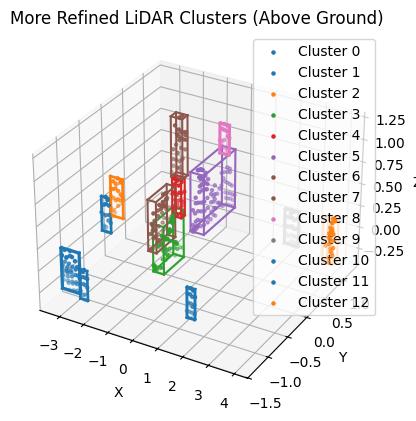

In [7]:
import re
import numpy as np
import struct

import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

# ---------------------------------------------
# 1) Parse the text file into NumPy
# ---------------------------------------------
def parse_pointcloud2_file(file_path):
    with open(file_path, 'r') as f:
        text = f.read()

    match = re.search(r'data=\[([^\]]*)\]', text)
    if not match:
        raise ValueError("Could not find 'data=[...]' block in file.")

    data_str = match.group(1)
    raw_values = [x.strip() for x in data_str.split(',') if x.strip()]
    byte_vals = np.array([int(v) for v in raw_values], dtype=np.uint8)

    step = 26
    fmt = '<4f2Bd'  # x,y,z,intensity => float32, tag,line => uint8, timestamp => float64
    n_points = len(byte_vals) // step

    points = []
    offset = 0
    for _ in range(n_points):
        chunk = byte_vals[offset:offset+step]
        offset += step
        x, y, z, intensity, tag, line, timestamp = struct.unpack(fmt, chunk.tobytes())
        points.append([x, y, z, intensity, tag, line, timestamp])

    return np.array(points, dtype=np.float64)

# ---------------------------------------------
# 2) DBSCAN + bounding boxes
# ---------------------------------------------
def cluster_points_dbscan(xyz, eps=0.2, min_samples=15):
    """
    Use a smaller eps so we get more clusters.
    Adjust min_samples to skip tiny clusters or noise.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(xyz)
    return db.labels_

def compute_bounding_boxes(xyz, labels):
    bboxes = []
    unique_labels = set(labels) - {-1}  # ignore outliers
    for cid in unique_labels:
        idx = np.where(labels == cid)[0]
        cluster_points = xyz[idx]
        xyz_min = cluster_points.min(axis=0)
        xyz_max = cluster_points.max(axis=0)
        bboxes.append({
            "cluster_id": cid,
            "min": tuple(xyz_min),
            "max": tuple(xyz_max)
        })
    return bboxes

# ---------------------------------------------
# 3) Plotting
# ---------------------------------------------
def draw_aabb(ax, xyz_min, xyz_max, color='r'):
    (xmin, ymin, zmin) = xyz_min
    (xmax, ymax, zmax) = xyz_max
    corners = np.array([
        [xmin, ymin, zmin], [xmin, ymin, zmax],
        [xmin, ymax, zmin], [xmin, ymax, zmax],
        [xmax, ymin, zmin], [xmax, ymin, zmax],
        [xmax, ymax, zmin], [xmax, ymax, zmax]
    ])
    edges = [
        (0,1), (0,2), (2,3), (1,3),
        (4,5), (4,6), (6,7), (5,7),
        (0,4), (1,5), (2,6), (3,7)
    ]
    for (start, end) in edges:
        ax.plot3D(
            [corners[start,0], corners[end,0]],
            [corners[start,1], corners[end,1]],
            [corners[start,2], corners[end,2]],
            color=color
        )

def plot_clusters_and_bboxes(xyz, labels, bboxes):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = set(labels) - {-1}
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    for cid in unique_labels:
        mask = (labels == cid)
        cluster_points = xyz[mask]
        color = colors(cid % 10)
        ax.scatter(
            cluster_points[:,0], cluster_points[:,1], cluster_points[:,2],
            s=5, c=[color], label=f"Cluster {cid}"
        )

    for box in bboxes:
        cid = box["cluster_id"]
        color = colors(cid % 10)
        draw_aabb(ax, box["min"], box["max"], color=color)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.title("More Refined LiDAR Clusters (Above Ground)")
    plt.show()

# ---------------------------------------------
# 4) Main
# ---------------------------------------------
if __name__ == "__main__":
    # Parse the file
    file_path = "/content/livox_data-2.txt"
    points = parse_pointcloud2_file(file_path)  # shape (N,7)

    # x,y,z only
    xyz_full = points[:, :3]

    # Convert to Open3D so we can remove ground
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz_full)

    # Downsample (helps DBSCAN separate objects)
    pcd_down = pcd.voxel_down_sample(voxel_size=0.1)

    # Remove ground plane
    dist_thresh = 0.2  # smaller => stricter ground removal
    plane_model, inliers = pcd_down.segment_plane(
        distance_threshold=dist_thresh,
        ransac_n=3,
        num_iterations=1000
    )
    pcd_ground    = pcd_down.select_by_index(inliers)
    pcd_obstacles = pcd_down.select_by_index(inliers, invert=True)

    # remove isolated outliers
    pcd_obstacles, _ = pcd_obstacles.remove_statistical_outlier(
        nb_neighbors=20,
        std_ratio=2.0
    )

    # Make a NumPy array of above-ground points
    xyz_obstacles = np.asarray(pcd_obstacles.points)

    # DBSCAN with smaller eps
    # Adjust eps & min_samples to get more but smaller clusters
    labels = cluster_points_dbscan(xyz_obstacles, eps=0.2, min_samples=15)
    n_clusters = len(set(labels) - {-1})
    print(f"DBSCAN => {n_clusters} clusters (excl. outliers)")

    # Bboxes
    bboxes = compute_bounding_boxes(xyz_obstacles, labels)

    # Filter out bboxes that are too big or too small
    final_bboxes = []
    for b in bboxes:
        (xmin, ymin, zmin) = b["min"]
        (xmax, ymax, zmax) = b["max"]
        dx, dy, dz = (xmax - xmin, ymax - ymin, zmax - zmin)
        if dx < 3.0 and dy < 3.0 and dz < 3.0 and (dx > 0.1 or dy > 0.1 or dz > 0.1):
            final_bboxes.append(b)

    # Print info
    for box in final_bboxes:
        cid = box["cluster_id"]
        (xmin, ymin, zmin) = box["min"]
        (xmax, ymax, zmax) = box["max"]
        print(f"Cluster {cid} => min=({xmin:.2f},{ymin:.2f},{zmin:.2f}) max=({xmax:.2f},{ymax:.2f},{zmax:.2f})")

    # Plot
    final_cids = [b["cluster_id"] for b in final_bboxes]
    # a label array that is -1 except for final clusters
    filtered_labels = np.array([-1]*len(labels))
    for b in final_bboxes:
        filtered_labels[ labels == b["cluster_id"] ] = b["cluster_id"]

    plot_clusters_and_bboxes(xyz_obstacles, filtered_labels, final_bboxes)
